In [1]:
# Packages (+pData while 1.1 isn't operational)

# %matplotlib qt
# %matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.animation

from scipy import io
import math
import csv
import time

from numpy import pi, cos, sin, sign

contents = io.loadmat('pData_mat.mat') #pData 1,50,20000
pData=contents['pData']
pData.shape


(20, 20000, 49)

# Data Analysis of Forces on Non-Spherical Intruders


## Read Data from Binary File

A file containing 20 variables for N number of particles for time t is to be opened, read, and stored. 

In [ ]:
NF = 20
filename = 'output_4_2__2_10mm_Rods.dat'

my_file = open(filename)
print(my_file)

In [ ]:
def readData(filename, startN, endN, maxParticles):
    NF = 20 #Number of data fields
    
    dt = np.dtype(np.float32)
    f = open(filename, "rb")

    p_data = np.zeros([NF,maxParticles,endN-startN])
    
    f.seek(0)
    for i in range(endN-startN):
        numParticles = np.fromfile(f, dtype=dt, count=1)
        time = np.fromfile(f, dtype=dt, count=1)
        temp = np.fromfile(f, dtype=dt, count=NF*int(numParticles)).reshape((int(numParticles), NF)).transpose()
        p_data[:,0:temp.shape[1],i] = temp
        del temp
    return p_data


In [ ]:
p_data = readData('output_4_2__2_10mm_Rods.dat', 1,50,20000)
# print(p_data[2,:,0], pData[2,:,0])

print(p_data==pData.all())


## Plot Data
Plot the received data as a 2D and 3D animation. The particles should be color mapped according to their magnitude of velocity. 

### 2D Scatter Plot (Plot2D): 'Frame' or 'Animate'

In [ ]:
%matplotlib qt
def Plot2D(t,frame):

    if t == 'Frame':
        xp, yp, zp =pData[2,:,frame],pData[4,:,frame],pData[3,:,frame]
        vp, wp, up =pData[6,:,frame],pData[7,:,frame],pData[8,:,frame]
        umag=np.sqrt(up**2+vp**2+wp**2)

        fig = plt.figure()
        ax = fig.add_subplot(111)

        # Axes Properties 
        ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_title('2D Test: Time = %i' %frame)

        ax.scatter(yp, zp, c=umag, cmap=cm.jet, s=0.1)
        plt.show()

    if t == 'Animate':
        time = frame #Set the time frame

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion() #Animate plot

        for i in range(time):    
            xp, yp, zp=pData[2,:,i],pData[4,:,i],pData[3,:,i]
            vp, wp, up =pData[6,:,i],pData[7,:,i],pData[8,:,i]
            umag=np.sqrt(up**2+vp**2+wp**2) # magnitude of velocity

            plt.scatter(yp,zp, s=.1, c=umag, cmap=cm.jet)
            plt.xlabel('Z'), plt.ylabel('Y'), plt.axis([0,1.0,0,1.0])
            plt.title('2D Scatter: Time = %i' %i)
            plt.draw()
            plt.pause(0.2)
            plt.clf()
        plt.waitforbuttonpress()

In [ ]:
Plot2D('Animate', 48)

### 3D Scatter Plot (Plot3D): 'Frame' or 'Animate'

In [ ]:
%matplotlib qt
def Plot3D(t, frame):
    if t == 'Frame':
        xp, yp, zp =pData[4,:,frame],pData[2,:,frame],pData[3,:,frame] # note: z in pData is x for python
        vp, wp, up =pData[6,:,frame], pData[7,:,frame], pData[8,:,frame]
        umag=np.sqrt(up**2+vp**2+wp**2)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
        ax.set_title('3D Scatter: Time = %i' %frame)

        ax.scatter(xp,yp,zp, c=umag, s=0.1)
    if t == 'Animate':
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        vp, wp, up =pData[6,:,0], pData[7,:,0], pData[8,:,0]
        umag=np.sqrt(up**2+vp**2+wp**2)
        sc = ax.scatter(pData[2,:,0], pData[4,:,0], pData[3,:,0], s = 0.1, c=umag, alpha = 0.5)

        def update(i):
            sc._offsets3d = (pData[2,:,i], pData[4,:,i], pData[3,:,i])
            vp, wp, up =pData[6,:,i], pData[7,:,i], pData[8,:,i]
            umag = np.sqrt(up**2+vp**2+wp**2)
            ax.set_title('3D Scatter: t = %i' %i)

        ax.set_xlabel('X'),ax.set_ylabel('Y'),ax.set_zlabel('Z')
        ax.view_init(20, 10)

        ani = matplotlib.animation.FuncAnimation(fig, update, frames=frame)
        return ani

In [ ]:
Plot3D('Frame', 48)

## Particle Shape and Volume

Assume we have two particles:
- Blue disks: d=6.35mm; l=3.175mm
- Red rods: d=3.175mm; l=4.75mm

We want to plot the shape of the disk and rod and then calculate their respective volume.

### Plot Superellipoids

In [2]:
def drawParticle(particle_id, frame):
    fig = plt.figure(figsize=(8,8))
    list_center = [(0,0,0)]
    list_radius = [1] #Default
    for c, r in zip(list_center, list_radius):
        ax = fig.gca(projection='3d')

        #Paramaters 
        particle, frame = 3,0
        SE_a, SE_b, SE_c = pData[11,particle_id,frame], pData[12,particle_id,frame], pData[13,particle_id,frame]
        s, t = 2, 8
        #Draw Superellipsoid
        w, n = np.mgrid[-pi:pi:50j, (-pi/2):(pi/2):50j]
        x = SE_a*(sign(cos(n))*abs(cos(n))**(2/t))*(sign(cos(w))*abs(cos(w))**(2/s))
        y = SE_b*(sign(cos(n))*abs(cos(n))**(2/t))*(sign(sin(w))*abs(sin(w))**(2/s))
        z = SE_c*(sign(sin(n))*abs(sin(n))**(2/t))

        ax.plot_surface(x-c[0], y-c[1], z-c[2], color='r', alpha=0.5*np.random.random()+0.5)
        ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
        ax.set_xlim(-0.002, 0.002), ax.set_ylim(-0.002,0.002), ax.set_zlim(-0.005,0.005)
        ax.set_title('Particle Number %i' %particle_id + ' at Time %i' %frame)

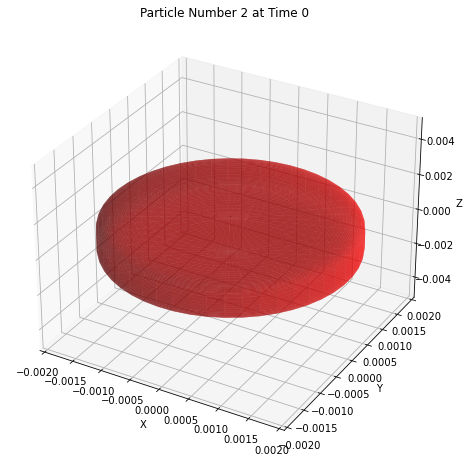

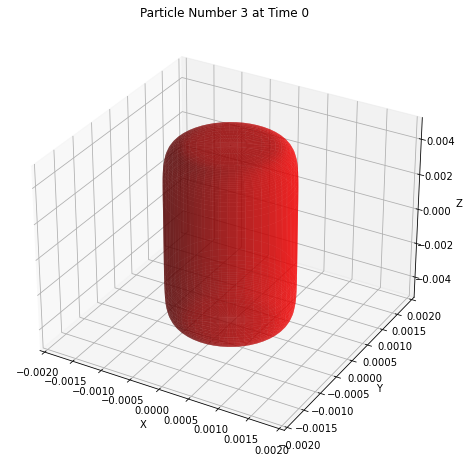

In [3]:
drawParticle(2,0)
drawParticle(3,0)

### Volume Calculation (s=2, t=8):

Calculate the volume of each particle.

- Particle 2, t=0 : a=0.002
- Particle 3, t=0: b=0.001

In [ ]:
np.max(pData[3,:,48])

In [ ]:
a = np.array(pData[11,:,48])
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

In [ ]:
frame = 0
for particle in (2,3):
    SE_a = pData[11,particle,frame]
    SE_b = pData[12,particle,frame]
    SE_c = pData[13,particle,frame]
    SE_s = pData[15,particle,frame] #Check s=15 or 14, bc outputs 2.0 and 8.0, resp
    SE_t = pData[14,particle,frame]

    V = 1.379061249756*SE_a*SE_b*SE_c
    print(particle, SE_a,SE_b,SE_c,V)

## Bins and Counting Particles

The goal of this section is to divide a 2D one time-frame plot into a set amount of bins and count the number of particles (and their type) within each bin. The next step is to take the volume and calculate the concentration of red or blue particles and graph.

In [ ]:
# 1 time frame of a 2D scatterplot divided into bins
def TimeFrameSc(frame,bin_num):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    xp,yp,zp=pData[4,:,frame],pData[3,:,frame],pData[2,:,frame] 
    vp,wp,up=pData[5,:,frame],pData[6,:,frame],pData[7,:,frame]
    umag=np.sqrt(up**2+vp**2+wp**2)

    # Axes Properties 
    bins = np.linspace(0,1,(bin_num+1)) #Divides into bins
    ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_title('2D Test: Time = %i' %frame)
    ax.set_xlim(0,1.0), ax.set_ylim(0,1.0)
    

    for i in bins:
        ax.axvline(x=i, c= 'r')

    ax.scatter(xp, yp, c=umag, cmap=cm.jet, s=0.1)
    return plt.show()

### Plot Particle Number per Bin

In [ ]:
# Lineplot of 1 timeframe, shows number of particles in each bin
def Prtc_Number(frame, bin_num):
    xp=pData[4,:,frame]
    yp=pData[3,:,frame]

    SE_a=pData[12,:,frame]

    bins = np.linspace(0,1,(bin_num+1))

    pt_data = []
    del pt_data
    pt_data = []

    for i in enumerate(bins):
        good_nums_1, good_nums_2 = 0,0
        for ii in range(len(yp)):    
            row =[]
            if i[1] < xp[ii] <= i[1]+bins[1] and SE_a[ii] == 0.0010000000474974513:
                good_nums_1 +=1
            if i[1] < xp[ii] <= i[1]+bins[1] and SE_a[ii] == 0.0020000000949949026:
                good_nums_2 +=1
        row.append(good_nums_1)
        row.append(good_nums_2)
        pt_data.append(row)
        del(good_nums_1, good_nums_2, row)

    pt_data = pt_data[:len(pt_data)-1]
    pt_data = np.array(pt_data)
    tot_num = sum(sum(pt_data))

    bin_avg = [x- bins[1]/2 for x in bins]
    bin_pts = np.delete(bin_avg, 0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    fig.suptitle('Concentration of Particles')
    ax1.plot(bin_pts, pt_data[:,0])
    ax2.plot(bin_pts, pt_data[:,1])
    ax1.title.set_text('No. of Particles: R1'), ax2.title.set_text('No. of Particles: D1')
    plt.setp(ax1, xlim=(0,1), ylim=(0,4000))
    plt.setp(ax2, xlim=(0,1), ylim=(0,4000))

    return

In [ ]:
%matplotlib inline
TimeFrameSc(48,5)
Prtc_Number(48,5)

### Plot Concentration per Bin

By dissertation: Concentration of species i, ci, in a bin equals sum of partial volume of particle j of species i over total volume of all particles in the bin.

In [ ]:
def Prtc_Conc(frame, bin_num):
    xp=pData[4,:,frame]
    yp=pData[3,:,frame]

    SE_a = pData[11,:,frame]
    SE_b = pData[12,:,frame]
    SE_c = pData[13,:,frame]

    bins = np.linspace(0,1,(bin_num+1))

    pt_data, V_tot_bin = [], []
    del pt_data, V_tot_bin
    pt_data = []
    V_tot_bin = []

    for i in enumerate(bins):
        V_1, V_2, V_tot = 0,0,0
        
        for ii in range(len(yp)):    
            row =[]
            if i[1] < xp[ii] <= i[1]+bins[1] and SE_a[ii] == 0.0010000000474974513:
                V_temp_1 = 1.379061249756*SE_a[ii]*SE_b[ii]*SE_c[ii]
                V_1 += V_temp_1
            if i[1] < xp[ii] <= i[1]+bins[1] and SE_a[ii] == 0.0020000000949949026:
                V_temp_2 = 1.379061249756*SE_a[ii]*SE_b[ii]*SE_c[ii]
                V_2 += V_temp_2
        V_tot = V_1 + V_2
        V_1_c = V_1/V_tot
        V_2_c = V_2/V_tot
        row.append(V_1_c)
        row.append(V_2_c)
        pt_data.append(row)
        del(V_1, V_2, row, V_tot)
    pt_data = pt_data[:len(pt_data)-1]
    pt_data = np.array(pt_data)


    bin_avg = [x- bins[1]/2 for x in bins]
    bin_pts = np.delete(bin_avg, 0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    fig.suptitle('Concentration of Particles')
    ax1.plot(bin_pts, pt_data[:,0])
    ax2.plot(bin_pts, pt_data[:,1])
    ax1.title.set_text('Concentration of Group 1'), ax2.title.set_text('Concentration of Group 2')
    ax1.set_xlim(0,1), ax2.set_xlim(0,1)
    ax1.set_ylim(0,1), ax2.set_ylim(0,1)
        
    return plt.show()

In [ ]:
TimeFrameSc(48,5)
Prtc_Conc(48,5)
Prtc_Conc(48,100)

## Histograms

In [4]:
## Gives concentration
def PlotConcentration(frame, bin_num):
    # Gathering Data
    df = pd.DataFrame(data={
        'xp': pData[4,:,frame],
        'SE_a': pData[11,:,frame],
        'SE_b': pData[12,:,frame],
        'SE_c': pData[13,:,frame]})
    df = df[df.SE_a != 0]
    df = df.assign(V = lambda x: (1.379061249756*x['SE_a']*x['SE_b']*x['SE_c']))
    SE_a_vals = df.SE_a.unique()
    SE_a_1 = df[df.SE_a == SE_a_vals[0]]
    SE_a_2 = df[df.SE_a == SE_a_vals[1]]

    #Divide into bins
    count_1, division_1 = np.histogram(SE_a_1['xp'], bins=bin_num)
    count_2, division_2 = np.histogram(SE_a_2['xp'], bins=bin_num)

    #Calculate Concentration
    vol_1, vol_2 = [], []
    for i in range(len(count_2)):
        vol_1.append((count_1[i]*SE_a_1.V.iloc[0])/(count_1[i]*SE_a_1.V.iloc[0] + count_2[i]*SE_a_2.V.iloc[0]))
        vol_2.append((count_2[i]*SE_a_2.V.iloc[0])/(count_1[i]*SE_a_1.V.iloc[0] + count_2[i]*SE_a_2.V.iloc[0]))


    # Plot Figure
    bin_centers = 0.5*(division_1[1:] + division_1[:-1])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,7))
    fig.suptitle('Concentration of Particles')
    ax1.plot(bin_centers, vol_1)
    ax2.plot(bin_centers, vol_2)    
    ax1.title.set_text('Concentration of Group 1'), ax2.title.set_text('Concentration of Group 2')
    ax1.set_xlim(0,1), ax2.set_xlim(0,1), ax1.set_ylim(0,1), ax2.set_ylim(0,1)

    return plt.show()

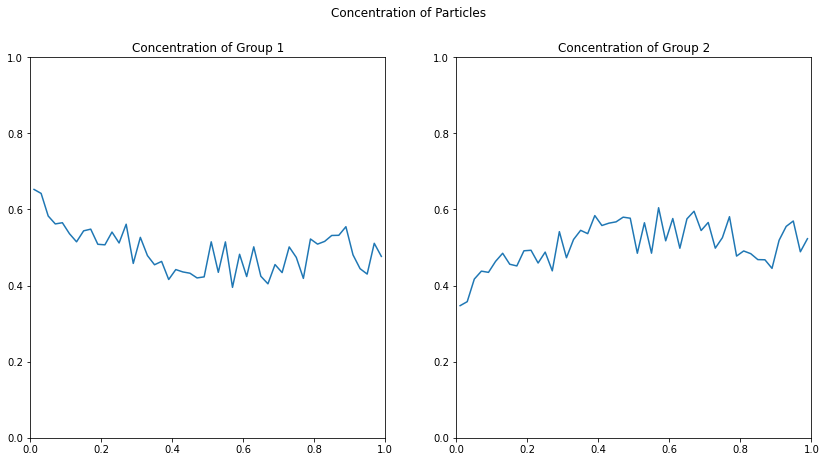

In [5]:
PlotConcentration(48,50)

### Histogram in 2D

In [ ]:
%matplotlib inline
bin_num = 5
frame = 48

df = pd.DataFrame(data={
    'xp': pData[4,:,frame],
    'yp': pData[2,:,frame],
    'zp': pData[3,:,frame],
    'SE_a': pData[11,:,frame],
    'SE_b': pData[12,:,frame],
    'SE_c': pData[13,:,frame]})
df = df[df.SE_a != 0]
df = df.assign(V = lambda x: (1.379061249756*x['SE_a']*x['SE_b']*x['SE_c']))

# # # Plot Figure
fig = plt.subplots(figsize =(10, 7)) 
plt.hist2d(df["xp"], df["zp"], bins = 10) 
plt.title("2D Histogram: Number Particles Total")  
plt.colorbar()
plt.show()


In [6]:
def Hist2D_Conc(frame, bin_num):
    #Gathering Data
    df = pd.DataFrame(data={
        'xp': pData[4,:,frame],
        'yp': pData[2,:,frame],
        'zp': pData[3,:,frame],
        'SE_a': pData[11,:,frame],
        'SE_b': pData[12,:,frame],
        'SE_c': pData[13,:,frame]
    })
    df = df[df.SE_a != 0]
    df = df.assign(V = lambda x: (1.379061249756*x['SE_a']*x['SE_b']*x['SE_c']))
    SE_a_vals = df.SE_a.unique()
    SE_a_1 = df[df.SE_a == SE_a_vals[0]]
    SE_a_2 = df[df.SE_a == SE_a_vals[1]]
    global zbins, xbins

    #Bins and calculating concentration
    hist_1, xbins, zbins = np.histogram2d(SE_a_1["xp"], SE_a_1["zp"], bins = bin_num) 
    hist_2, xbins, zbins = np.histogram2d(SE_a_2["xp"], SE_a_2["zp"], bins = bin_num) 

    vol_1 = hist_1*SE_a_1.V.iloc[0]
    vol_2 = hist_2*SE_a_2.V.iloc[0]

    c_1 = vol_1/(vol_1+vol_2)
    c_2 = vol_2/(vol_1+vol_2)

    #Figures
    fig, (ax1, ax2, cax) = plt.subplots(1,3, figsize=(15,8), gridspec_kw={"width_ratios":[1,1, 0.05]})
    fig.suptitle('Concentration of Particles')
    im= ax1.imshow(c_1.T, origin ='lower')
    im2= ax2.imshow(c_2.T, origin='lower')
    ax1.title.set_text('Concentration of Group 1'), ax2.title.set_text('Concentration of Group 2')
    fig.colorbar(im, cax=cax)
    return plt.show()

<ipython-input-6-0e77e1703c3c>:25: RuntimeWarning: invalid value encountered in true_divide
  c_1 = vol_1/(vol_1+vol_2)
<ipython-input-6-0e77e1703c3c>:26: RuntimeWarning: invalid value encountered in true_divide
  c_2 = vol_2/(vol_1+vol_2)


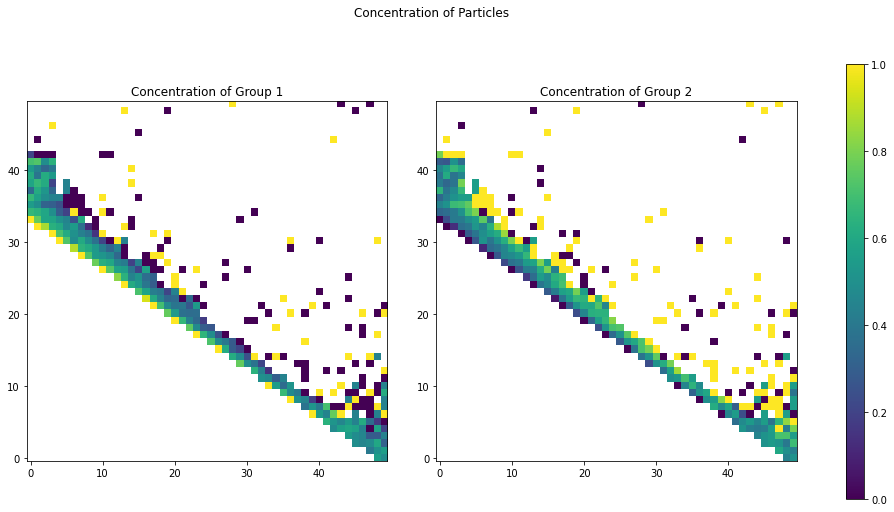

In [7]:
Hist2D_Conc(48,50)

In [ ]:
#Segregation 

print(pData[11,0,0], pData[12,0,0], pData[13,0,0])

## Orientation

In [ ]:
a = np.array(pData[16,:,48])
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

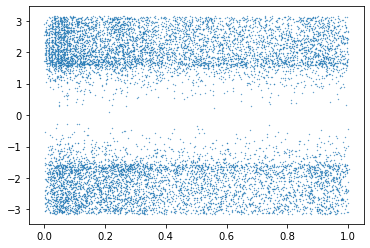

In [8]:
from pyquaternion import Quaternion
particle = 0
frame = 0

df = pd.DataFrame(data={
    'xp': pData[4,:,frame],
    'SE_a': pData[11,:,frame],
    'SE_b': pData[12,:,frame],
    'SE_c': pData[13,:,frame],
    'q1': pData[16,:,frame],
    'q2': pData[17,:,frame],
    'q3': pData[18,:,frame],
    'q4': pData[19,:,frame]})
df = df[df.SE_a != 0]
SE_a_vals = df.SE_a.unique()
SE_a_1 = df[df.SE_a == SE_a_vals[0]]

q=[]
r_angles=[]
for i in range(len(df['q1'])):
    q.append(Quaternion(df.q1.iloc[i], df.q2.iloc[i], df.q3.iloc[i], df.q4.iloc[i]))
    r_angles.append(q[i].radians)
    
df['r_angles'] = r_angles

plt.scatter(df['xp'], df['r_angles'], s=.1 )

In [ ]:
from pyquaternion import Quaternion
particle = 0
frame = 0

df = pd.DataFrame(data={
    'xp': pData[4,:,frame],
    'SE_a': pData[11,:,frame],
    'SE_b': pData[12,:,frame],
    'SE_c': pData[13,:,frame],
    'q1': pData[16,:,frame],
    'q2': pData[17,:,frame],
    'q3': pData[18,:,frame],
    'q4': pData[19,:,frame]})
df = df[df.SE_a != 0]
SE_a_vals = df.SE_a.unique()
SE_a_1 = df[df.SE_a == SE_a_vals[1]]

q=[]
r_angles=[]
for i in range(len(df['q1'])):
    q.append(Quaternion(df.q1.iloc[i], df.q2.iloc[i], df.q3.iloc[i], df.q4.iloc[i]))
    r_angles.append(q[i].radians)
    
df['r_angles'] = r_angles

plt.scatter(df['xp'], df['r_angles'], s=.1 )